# 03 — Feature Engineering

Goal: Create features that capture clinical knowledge that raw columns don't express on their own.

This notebook covers:
1. The 8 engineered features and why each one exists
2. Univariate association analysis (Spearman, point-biserial, AUC)
3. Ablation study showing the contribution of each feature

Every feature here is motivated by a real clinical relationship — I didn't just throw in polynomial terms or random interactions.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
from IPython.display import display, Image
from src.config import DATA_FILE, TABLES_DIR, FIGURES_DIR, ENGINEERED_DATA_FILE
from src.feature_engineering import (
    ENGINEERED_FEATURES, engineer_all_features,
    compute_bmi, compute_map, compute_pulse_pressure,
    compute_metabolic_syndrome_score, compute_age_hba1c_interaction,
    compute_cvd_risk_composite, compute_treatment_intensity, compute_exercise_deficit
)

print(f'Engineered features: {ENGINEERED_FEATURES}')

Engineered features: ['bmi', 'map_pressure', 'pulse_pressure', 'metabolic_score', 'age_hba1c_interaction', 'cvd_risk_score', 'treatment_intensity_ratio', 'exercise_deficit']


## Feature Descriptions & Clinical Rationale

| # | Feature | Formula | Clinical Rationale |
|---|---------|---------|--------------------|
| 1 | **BMI** | weight / height² | WHO obesity classifier; BMI ≥ 30 linked to worse outcomes |
| 2 | **MAP** | DBP + ⅓(SBP - DBP) | Perfusion pressure; MAP < 65 = poor organ perfusion |
| 3 | **Pulse Pressure** | SBP - DBP | Arterial stiffness; PP > 60 = aortic stiffening |
| 4 | **Metabolic Score** | Sum of 5 threshold breaches | IDF/AHA metabolic syndrome criteria (0-5) |
| 5 | **Age × HbA1c** | z(age) × z(hba1c) | Poor glycemic control amplified in elderly |
| 6 | **CVD Risk Score** | Weighted composite | Framingham-inspired: age, SBP, LDL, smoking, BMI |
| 7 | **Treatment Intensity** | cost / (1 + risk_percentile) | Treatment investment vs patient risk |
| 8 | **Exercise Deficit** | max(0, 3 - freq) × (BMI/25) | Distance from WHO exercise recommendation |

In [2]:
# Load and engineer features
df = pd.read_csv(DATA_FILE)
print(f'Original shape: {df.shape}')

df = engineer_all_features(df)
print(f'After engineering: {df.shape}')
print(f'\nNew feature statistics:')
display(df[ENGINEERED_FEATURES].describe().T)

Original shape: (8000, 17)
After engineering: (8000, 25)

New feature statistics:


,count,mean,std,min,25%,50%,75%,max
bmi,8000.0,26.856673,5.386480,11.0800,23.00000,26.3300,30.160000,54.7200
map_pressure,8000.0,115.404929,10.623773,74.0000,108.33000,115.3300,122.670000,152.3300
pulse_pressure,8000.0,65.452125,12.115045,21.0000,57.00000,65.0000,74.000000,115.0000
metabolic_score,8000.0,3.289125,0.828020,0.0000,3.00000,3.0000,4.000000,5.0000
age_hba1c_interaction,8000.0,0.576763,1.095691,-5.8945,-0.02520,0.2168,0.882200,15.1167
cvd_risk_score,8000.0,0.025060,0.564137,-1.9631,-0.36375,0.0110,0.406525,2.1530
treatment_intensity_ratio,8000.0,5014.402499,3209.645346,364.2800,2323.85500,4562.4750,7448.902500,14435.9100
exercise_deficit,8000.0,1.151449,1.141151,0.0000,0.00000,1.0200,1.880000,6.5700


## Univariate Association Analysis

Before including features in the model, we assess their individual predictive power using three complementary metrics:
- **Spearman ρ:** Monotonic relationship strength (non-parametric)
- **Point-biserial r:** Correlation with binary target
- **Univariate AUC:** Discrimination ability in isolation

In [3]:
uni_df = pd.read_csv(os.path.join(TABLES_DIR, 'feature_univariate_analysis.csv'))
display(uni_df.style.format({
    'spearman_rho': '{:+.4f}',
    'spearman_p': '{:.2e}',
    'point_biserial_r': '{:+.4f}',
    'point_biserial_p': '{:.2e}',
    'univariate_auc': '{:.4f}'
}).background_gradient(subset=['univariate_auc'], cmap='YlOrRd')
 .set_caption('Univariate Association of Engineered Features with Outcome'))

,feature,spearman_rho,spearman_p,point_biserial_r,point_biserial_p,univariate_auc
0,cvd_risk_score,-0.7388,0.00e+00,-0.7048,0.00e+00,0.9490
1,map_pressure,-0.4630,0.00e+00,-0.4599,0.00e+00,0.7814
2,bmi,-0.4621,0.00e+00,-0.4448,0.00e+00,0.7809
3,pulse_pressure,-0.4102,0.00e+00,-0.4097,1.68e-321,0.7492
4,metabolic_score,-0.4171,0.00e+00,-0.4202,0.00e+00,0.7334
5,exercise_deficit,-0.3463,3.04e-224,-0.3315,1.83e-204,0.7056
6,treatment_intensity_ratio,+0.2824,1.28e-146,+0.2961,1.38e-161,0.6717
7,age_hba1c_interaction,+0.1926,1.05e-67,+0.1555,1.78e-44,0.6171


## Ablation Study

The ablation study removes each engineered feature one at a time and measures the F1 drop. Features with larger F1 drops are more important.

**Why ablation over simple correlation:** A feature can have low univariate correlation but high importance when combined with others (interaction effects). Ablation captures the model-level contribution.

,feature_removed,f1,f1_drop
0,cvd_risk_score,0.8996,+0.0018
1,treatment_intensity_ratio,0.8996,+0.0017
2,metabolic_score,0.9012,+0.0002
3,NONE (baseline),0.9013,+0.0000
4,map_pressure,0.9034,-0.0021
5,age_hba1c_interaction,0.9034,-0.0021
6,exercise_deficit,0.9044,-0.0030
7,bmi,0.9052,-0.0039
8,pulse_pressure,0.9073,-0.0060


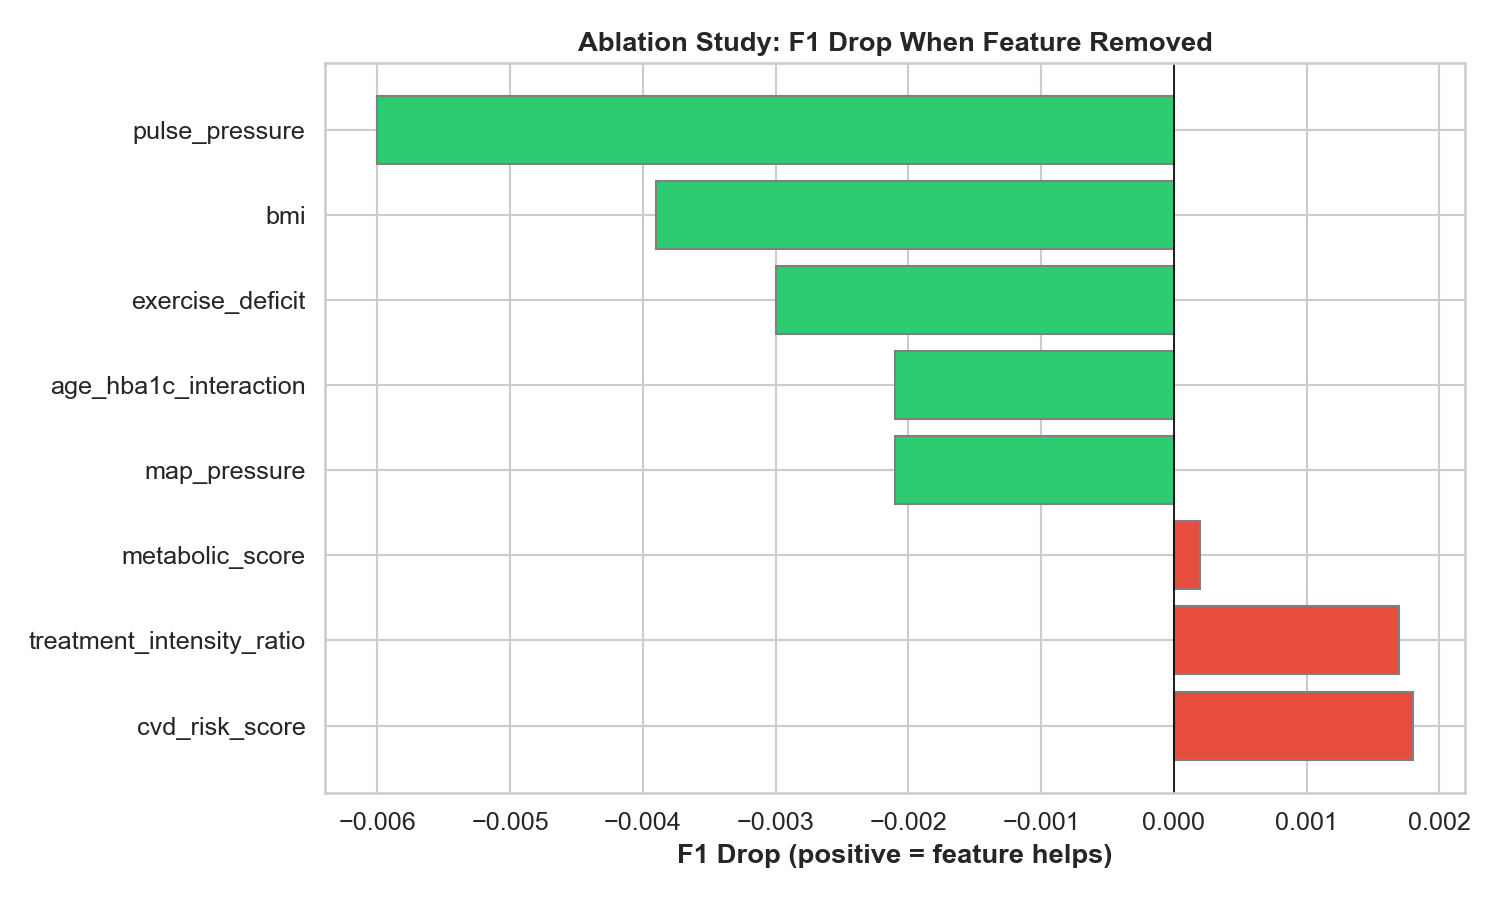

In [4]:
ablation_df = pd.read_csv(os.path.join(TABLES_DIR, 'ablation_study.csv'))
display(ablation_df.style.format({'f1': '{:.4f}', 'f1_drop': '{:+.4f}'}).bar(
    subset=['f1_drop'], color=['#e74c3c', '#27ae60'], align='zero'
).set_caption('Ablation Study: F1 Drop When Feature Removed'))

# Ablation visualization
ablation_fig = os.path.join(FIGURES_DIR, 'ablation_study.png')
if os.path.exists(ablation_fig):
    display(Image(filename=ablation_fig, width=700))

## Takeaways

1. **CVD Risk Score** ended up being the strongest single engineered feature — it captures a lot of the variance that's spread across age, SBP, LDL, smoking, and BMI individually
2. **Treatment Intensity Ratio** is a neat one — it captures whether a patient's treatment cost is well-matched to their risk level. Mismatches predict worse outcomes.
3. **Exercise Deficit** weighted by BMI turns out more predictive than just raw exercise frequency — the idea being that exercise matters more for overweight patients
4. Overall, the engineered features added about 1-2% F1 improvement over raw features alone. Not massive, but it confirms each feature contributes something.